In [1]:
%load_ext autoreload

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s') # NOTSET, DEBUG, INFO, WARN, ERROR, CRITICAL

from JPAS_DA import global_setup
from JPAS_DA.data import loading_tools
from JPAS_DA.data import cleaning_tools
from JPAS_DA.data import crossmatch_tools

import numpy as np

from JPAS_DA.utils import plotting_utils
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('default')
plt.close('all')
font, rcnew = plotting_utils.matplotlib_default_config()
mpl.rc('font', **font)
plt.rcParams.update(rcnew)
plt.style.use('tableau-colorblind10')
%matplotlib widget

In [2]:
root_path = global_setup.DATA_path
load_JPAS_x_DESI_Raul   = global_setup.load_JPAS_x_DESI_Raul
load_DESI_mocks_Raul    = global_setup.load_DESI_mocks_Raul
load_Ignasi             = global_setup.load_Ignasi

random_seed_load = global_setup.default_seed

In [3]:
DATA = loading_tools.load_data_bundle(
    root_path=root_path,
    include=["JPAS_x_DESI_Raul", "DESI_mocks_Raul", "Ignasi"],
    JPAS_x_DESI_Raul={"datasets": load_JPAS_x_DESI_Raul},
    DESI_mocks_Raul={"datasets": load_DESI_mocks_Raul},
    Ignasi={"datasets": load_Ignasi},
    random_seed=random_seed_load,
)

2025-09-17 14:21:10,937 - INFO - 📥 Starting modular dataset loading (load_data_bundle)
2025-09-17 14:21:10,937 - INFO - ├── Loading JPAS_x_DESI_Raul ...
2025-09-17 14:21:10,937 - INFO - ├─── 📥 Starting JPAS_x_DESI_Raul dataset loading...
2025-09-17 14:21:10,938 - INFO - |    ├─── 🔹 Dataset: all (sample 100%)
2025-09-17 14:21:10,985 - INFO - |    |    ✔ CSV loaded: JPAS_DATA_PROPERTIES.csv (shape: (52020, 18))
2025-09-17 14:21:10,997 - INFO - |    |    ✔ NPY loaded: JPAS_DATA_Aper_Cor_3_FLUX+NOISE.npy (obs shape: (52020, 57))
2025-09-17 14:21:10,998 - WARNING - |    |    ⚠ No pickle file provided or file does not exist: /home/dlopez/Documentos/0.profesional/Postdoc/USP/Projects/JPAS_Domain_Adaptation/DATA/JPAS_DATA_PROPERTIES_AUX.pkl
2025-09-17 14:21:10,998 - INFO - ├─── ✅ Finished loading all JPAS datasets.
2025-09-17 14:21:10,999 - INFO - │   ✔ Loaded JPAS_x_DESI_Raul
2025-09-17 14:21:10,999 - INFO - ├── Loading DESI_mocks_Raul ...
2025-09-17 14:21:10,999 - INFO - ├─── 📥 Loading DESI 

In [4]:
print(DATA["Ignasi"]['all_pd'].keys())
print(DATA["JPAS_x_DESI_Raul"]['all_pd'].keys())
print(DATA["DESI_mocks_Raul"]['all_pd'].keys())

print(DATA["Ignasi"]['all_observations'].shape)
print(DATA["JPAS_x_DESI_Raul"]['all_observations'].shape)
print(DATA["DESI_mocks_Raul"]['all_observations'].shape)

dict_keys(['DESI_FLUX_G', 'DESI_FLUX_R', 'DESI_FLUX_Z', 'DESI_MAG_G', 'DESI_MAG_R', 'DESI_MAG_Z', 'GAIA_PHOT_BP_MEAN_MAG', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_PHOT_RP_MEAN_MAG', 'HEALPIX', 'JPAS_DEC', 'JPAS_RA', 'MORPHTYPE', 'PROGRAM', 'SPECID', 'SPECTYPE', 'SUBTYPE', 'SURVEY', 'TARGETID', 'TARGET_DEC', 'TARGET_RA', 'ZERR_DESI', 'ZWARN', 'Z_DESI', 'class', 'class_CBM', 'class_SQUEzE', 'class_TRANS', 'conf_SQUEzE_0', 'conf_SQUEzE_1', 'conf_SQUEzE_2', 'conf_SQUEzE_3', 'conf_SQUEzE_4', 'conf_gal', 'conf_gal_CBM', 'conf_gal_TRANS', 'conf_hqso', 'conf_hqso_CBM', 'conf_hqso_TRANS', 'conf_lqso', 'conf_lqso_CBM', 'conf_lqso_TRANS', 'conf_star', 'conf_star_CBM', 'conf_star_TRANS', 'is_in_desi_dr1', 'label_TRANS', 'match_sep_arcsec', 'z', 'z_SQUEzE_0', 'z_SQUEzE_1', 'z_SQUEzE_2', 'z_SQUEzE_3', 'z_SQUEzE_4', 'z_TRANS', 'z_err_TRANS', 'ALPHA_J2000', 'A_WORLD', 'B_WORLD', 'CLASS_STAR', 'DELTA_J2000', 'FLAGS', 'FWHM_WORLD', 'ISOAREA_WORLD', 'KRON_RADIUS', 'MAG_AUTO', 'MASK_FLAGS', 'R_EFF', 'Separation', '

In [5]:
config_dict_cleaning = global_setup.config_dict_cleaning

In [6]:
DATA = cleaning_tools.clean_data_pipeline(DATA, config=config_dict_cleaning, in_place=True)

2025-09-17 14:21:33,763 - INFO - 🧹 Cleaning dataset: JPAS_x_DESI_Raul
2025-09-17 14:21:33,763 - INFO - ├── mask_out_unreliable_columns(mask_unreliable_filters_indices=[0, -2])
2025-09-17 14:21:33,772 - INFO - │   ├── Removed columns: [0, 55]
2025-09-17 14:21:33,772 - INFO - │   ├── New #filters: 55
2025-09-17 14:21:33,772 - INFO - │   ├── Updated observations shape: (52020, 55)
2025-09-17 14:21:33,772 - INFO - │   ├── Updated errors shape: (52020, 55)
2025-09-17 14:21:33,773 - INFO - ├── remove_NaNs(check='both', keep_rows_partially_filled_with_NaNs=True)
2025-09-17 14:21:33,774 - INFO - │   ├── rows fully NaN (drop): 0/52020 (0.00%)
2025-09-17 14:21:33,775 - INFO - │   ├── rows with SOME NaNs:   0/52020 (0.00%)
2025-09-17 14:21:33,775 - INFO - │   ├── rows dropped due to policy: 0/52020
2025-09-17 14:21:33,775 - INFO - │   └── final kept: 52020/52020 (100.00%)
2025-09-17 14:21:33,862 - INFO - ├── remove_magic_rows(check='obs', keep_rows_partially_filled_with_magic=True, magic_numbers=

In [7]:
print(DATA["Ignasi"].keys())
print(DATA["JPAS_x_DESI_Raul"].keys())
print(DATA["DESI_mocks_Raul"].keys())

print(DATA["Ignasi"]['all_pd'].keys())
print(DATA["JPAS_x_DESI_Raul"]['all_pd'].keys())
print(DATA["DESI_mocks_Raul"]['all_pd'].keys())

print(DATA["Ignasi"]['all_observations'].shape)
print(DATA["JPAS_x_DESI_Raul"]['all_observations'].shape)
print(DATA["DESI_mocks_Raul"]['all_observations'].shape)

dict_keys(['all_pd', 'all_observations', 'all_errors', 'all_observations_normalized', 'all_errors_normalized', 'normalization'])
dict_keys(['all_pd', 'all_observations', 'all_errors', 'all_observations_normalized', 'all_errors_normalized', 'normalization'])
dict_keys(['all_pd', 'all_observations', 'all_errors', 'all_observations_normalized', 'all_errors_normalized', 'normalization'])
dict_keys(['DESI_FLUX_G', 'DESI_FLUX_R', 'DESI_FLUX_Z', 'DESI_MAG_G', 'DESI_MAG_R', 'DESI_MAG_Z', 'GAIA_PHOT_BP_MEAN_MAG', 'GAIA_PHOT_G_MEAN_MAG', 'GAIA_PHOT_RP_MEAN_MAG', 'HEALPIX', 'JPAS_DEC', 'JPAS_RA', 'MORPHTYPE', 'PROGRAM', 'SPECID', 'SPECTYPE', 'SUBTYPE', 'SURVEY', 'TARGETID', 'TARGET_DEC', 'TARGET_RA', 'ZERR_DESI', 'ZWARN', 'Z_DESI', 'class', 'class_CBM', 'class_SQUEzE', 'class_TRANS', 'conf_SQUEzE_0', 'conf_SQUEzE_1', 'conf_SQUEzE_2', 'conf_SQUEzE_3', 'conf_SQUEzE_4', 'conf_gal', 'conf_gal_CBM', 'conf_gal_TRANS', 'conf_hqso', 'conf_hqso_CBM', 'conf_hqso_TRANS', 'conf_lqso', 'conf_lqso_CBM', 'conf_

In [8]:
Dict_LoA = {"intersection": {}, "outersection": {}}
IDs_only_DESI, IDs_only_JPAS, IDs_both, \
Dict_LoA["outersection"]["DESI_mocks_Raul"], Dict_LoA["outersection"]["JPAS_x_DESI_Raul"], \
Dict_LoA["intersection"]["DESI_mocks_Raul"], Dict_LoA["intersection"]["JPAS_x_DESI_Raul"] = crossmatch_tools.crossmatch_IDs_two_datasets(
    DATA["DESI_mocks_Raul"]['all_pd']['TARGETID'], DATA["JPAS_x_DESI_Raul"]['all_pd']['TARGETID']
)

2025-09-17 14:22:17,724 - INFO - 🔍 crossmatch_IDs_two_datasets()...
2025-09-17 14:22:17,725 - INFO - ├── 🚀 Starting ID categorization process...
2025-09-17 14:22:17,879 - INFO - |    ├── 📌 Found 1051168 unique IDs across 2 arrays.
2025-09-17 14:22:18,499 - INFO - |    ├── Presence matrix created with shape: (2, 1051168)
2025-09-17 14:22:18,503 - INFO - |    ├── Category mask created with shape: (2, 1051168)
2025-09-17 14:22:18,503 - INFO - ├── 🚀 Starting index retrieval process...
2025-09-17 14:22:18,503 - INFO - |    ├── 📌 Processing 1051168 unique IDs across 2 arrays.
2025-09-17 14:22:19,046 - INFO - ├── 🚀 Starting post-processing of unique IDs across two arrays...
2025-09-17 14:22:19,064 - INFO - |    ├── Processing complete: 1014323 IDs only in Array 1 (96.49%).
2025-09-17 14:22:19,064 - INFO - |    ├── Processing complete: 8 IDs only in Array 2 (0.0%).
2025-09-17 14:22:19,064 - INFO - |    ├── Processing complete: 36837 IDs in both arrays (3.5%).
2025-09-17 14:22:19,065 - INFO - ✅

In [9]:
print("=== Outersection ===")
print(f"DESI_mocks_Raul groups: {len(Dict_LoA['outersection']['DESI_mocks_Raul'])}")
print(f"DESI_mocks_Raul total IDs: {len(np.concatenate(Dict_LoA['outersection']['DESI_mocks_Raul']))}")
print()
print(f"JPAS_x_DESI_Raul groups: {len(Dict_LoA['outersection']['JPAS_x_DESI_Raul'])}")
print(f"JPAS_x_DESI_Raul total IDs: {len(np.concatenate(Dict_LoA['outersection']['JPAS_x_DESI_Raul']))}")

print("\n=== Intersection ===")
print(f"DESI_mocks_Raul groups: {len(Dict_LoA['intersection']['DESI_mocks_Raul'])}")
print(f"DESI_mocks_Raul total IDs: {len(np.concatenate(Dict_LoA['intersection']['DESI_mocks_Raul']))}")
print()
print(f"JPAS_x_DESI_Raul groups: {len(Dict_LoA['intersection']['JPAS_x_DESI_Raul'])}")
print(f"JPAS_x_DESI_Raul total IDs: {len(np.concatenate(Dict_LoA['intersection']['JPAS_x_DESI_Raul']))}")

=== Outersection ===
DESI_mocks_Raul groups: 1014323
DESI_mocks_Raul total IDs: 3166639

JPAS_x_DESI_Raul groups: 8
JPAS_x_DESI_Raul total IDs: 8

=== Intersection ===
DESI_mocks_Raul groups: 36837
DESI_mocks_Raul total IDs: 117721

JPAS_x_DESI_Raul groups: 36837
JPAS_x_DESI_Raul total IDs: 36837


2025-09-17 14:22:19,548 - INFO - 🔍 crossmatch_IDs_two_datasets()...
2025-09-17 14:22:19,548 - INFO - ├── 🚀 Starting ID categorization process...
2025-09-17 14:22:19,702 - INFO - |    ├── 📌 Found 1051168 unique IDs across 2 arrays.
2025-09-17 14:22:20,324 - INFO - |    ├── Presence matrix created with shape: (2, 1051168)
2025-09-17 14:22:20,328 - INFO - |    ├── Category mask created with shape: (2, 1051168)
2025-09-17 14:22:20,328 - INFO - ├── 🚀 Starting index retrieval process...
2025-09-17 14:22:20,328 - INFO - |    ├── 📌 Processing 1051168 unique IDs across 2 arrays.
2025-09-17 14:22:20,868 - INFO - ├── 🚀 Starting post-processing of unique IDs across two arrays...
2025-09-17 14:22:20,884 - INFO - |    ├── Processing complete: 8 IDs only in Array 1 (0.0%).
2025-09-17 14:22:20,885 - INFO - |    ├── Processing complete: 1014323 IDs only in Array 2 (96.49%).
2025-09-17 14:22:20,885 - INFO - |    ├── Processing complete: 36837 IDs in both arrays (3.5%).
2025-09-17 14:22:20,885 - INFO - ✅

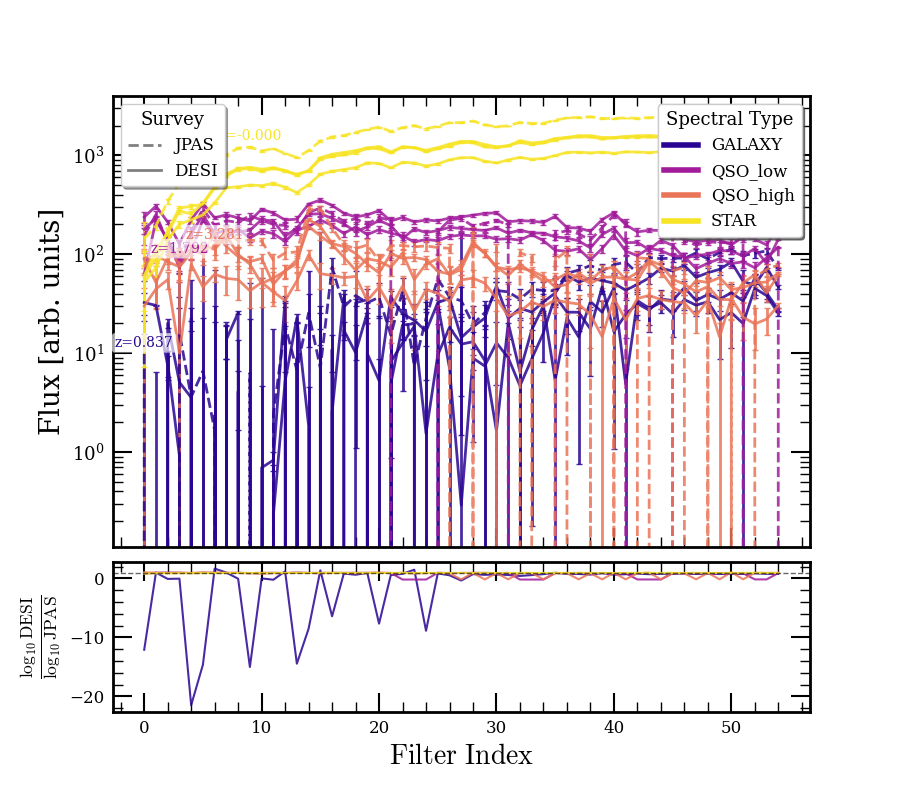

In [10]:
# --- Settings ---
survey_jpas = "JPAS_x_DESI_Raul"
survey_desi = "DESI_mocks_Raul"
NN = 1  # samples per spectral class

# --- Pull arrays we need
ids_jpas = np.asarray(DATA[survey_jpas]['all_pd']['TARGETID'])
ids_desi = np.asarray(DATA[survey_desi]['all_pd']['TARGETID'])

# --- Crossmatch to get intersection and per-ID indices
IDs_only_1, IDs_only_2, IDs_both, idxs_only_1, idxs_only_2, idxs_both_jpas, idxs_both_desi = (
    crossmatch_tools.crossmatch_IDs_two_datasets(ids_jpas, ids_desi)
)

# --- Build a quick lookup from TARGETID -> (indices in JPAS, indices in DESI)
id2idx = {}
for tid, ij, idesi in zip(IDs_both, idxs_both_jpas, idxs_both_desi):
    id2idx[tid] = {survey_jpas: np.atleast_1d(ij), survey_desi: np.atleast_1d(idesi)}

# --- Build the "matched JPAS" flat index list to choose samples by class
matched_JPAS_idx = np.concatenate(idxs_both_jpas) if len(idxs_both_jpas) else np.array([], dtype=int)

matched_SPECTYPE_int = np.asarray(DATA[survey_jpas]['all_pd']['SPECTYPE_int'])[matched_JPAS_idx]
matched_SPECTYPE_str = np.asarray(DATA[survey_jpas]['all_pd']['SPECTYPE'])[matched_JPAS_idx]
matched_TARGETID     = ids_jpas[matched_JPAS_idx]

# --- Unique classes (by integer code), and a stable string name per code
uniq_ints = np.unique(matched_SPECTYPE_int)
# map int code -> a representative string label (first seen)
int2label = {}
for u in uniq_ints:
    pos = np.flatnonzero(matched_SPECTYPE_int == u)
    int2label[int(u)] = str(matched_SPECTYPE_str[pos[0]]) if pos.size else f"class_{u}"

# --- Sample NN TARGETIDs per class (from the matched-JPAS subset)
rng = np.random.default_rng(0)
sampled_TARGETIDs = []
for code in uniq_ints:
    pos = np.flatnonzero(matched_SPECTYPE_int == code)
    if pos.size == 0:
        continue
    pick = rng.choice(pos, size=min(NN, pos.size), replace=False)
    sampled_TARGETIDs.append(matched_TARGETID[pick])
# shape ~ (n_classes, up to NN)
sampled_TARGETIDs = np.array(sampled_TARGETIDs, dtype=object)

# --- Plot setup (main + ratio)
fig, (ax, ax_ratio) = plt.subplots(
    2, 1, figsize=(9, 8), height_ratios=[3, 1], sharex=True, gridspec_kw={'hspace': 0.05}
)
ax.set_ylabel(r'Flux [arb. units]', fontsize=20)
ax_ratio.set_xlabel(r'$\mathrm{Filter~Index}$', fontsize=20)
ax_ratio.set_ylabel(r'$\frac{\log_{10}\mathrm{DESI}}{\log_{10}\mathrm{JPAS}}$', fontsize=18)

# Colors: one per spectral class
colors = plt.cm.plasma(np.linspace(0.05, 0.95, len(uniq_ints)))
linestyles = {survey_jpas: "--", survey_desi: "-"}

# --- Plot
label_lines_done = {survey_jpas: False, survey_desi: False}
ll = 0  # for staggered redshift text placement

for j, code in enumerate(uniq_ints):
    if j >= len(sampled_TARGETIDs):
        continue
    for k in range(len(sampled_TARGETIDs[j])):
        tid = sampled_TARGETIDs[j][k]
        if tid is None:
            continue
        # indices for this TARGETID in each dataset (use all occurrences)
        for key_survey in (survey_jpas, survey_desi):
            idxs = id2idx.get(tid, {}).get(key_survey, np.array([], dtype=int))
            for idx in np.atleast_1d(idxs):
                obs = np.asarray(DATA[key_survey]['all_observations'][idx], dtype=float)
                err = np.asarray(DATA[key_survey]['all_errors'][idx], dtype=float)
                z   = DATA[key_survey]['all_pd'].get('REDSHIFT', [np.nan])[idx]

                lbl = None
                if not label_lines_done[key_survey]:
                    lbl = "JPAS" if key_survey == survey_jpas else "DESI"
                    label_lines_done[key_survey] = True

                ax.errorbar(
                    np.arange(obs.size), obs, yerr=err,
                    capsize=2, lw=2.0, ls=linestyles[key_survey],
                    color=colors[j], ecolor=colors[j], alpha=0.85, label=lbl
                )

                # annotate redshift on JPAS curves
                if key_survey == survey_jpas and np.isfinite(z):
                    mid_idx = (ll % max(1, obs.size // 3)) * 3
                    mid_idx = min(mid_idx, obs.size - 1)
                    mid_y = obs[mid_idx] if np.isfinite(obs[mid_idx]) and obs[mid_idx] > 0 else np.nan
                    if np.isfinite(mid_y) and mid_y > 0:
                        ax.text(
                            mid_idx, mid_y * 1.1, f"z={z:.3f}",
                            fontsize=10, color=colors[j], ha='center', va='bottom',
                            bbox=dict(facecolor='white', edgecolor='none', alpha=0.65, boxstyle="round,pad=0.2")
                        )
                        ll += 1

        # ratio plot (use first occurrence in each)
        idxs_j = id2idx.get(tid, {}).get(survey_jpas, np.array([], dtype=int))
        idxs_d = id2idx.get(tid, {}).get(survey_desi, np.array([], dtype=int))
        if idxs_j.size and idxs_d.size:
            obs_j = np.asarray(DATA[survey_jpas]['all_observations'][idxs_j[0]], dtype=float)
            obs_d = np.asarray(DATA[survey_desi]['all_observations'][idxs_d[0]], dtype=float)
            # safe logs
            j_safe = np.log10(np.clip(obs_j, 1e-12, None))
            d_safe = np.log10(np.clip(obs_d, 1e-12, None))
            ratio = d_safe / np.where(j_safe == 0, np.nan, j_safe)
            ax_ratio.plot(np.arange(ratio.size), ratio, color=colors[j], ls="-", lw=1.5, alpha=0.85)

# Styling
ax.axhline(0, ls='--', lw=0.7, color='black', alpha=0.4)
ax.set_yscale("log")
ax.tick_params(axis='both', labelsize=13)
ax_ratio.axhline(1.0, ls='--', lw=1.0, color='black', alpha=0.6)
ax_ratio.tick_params(axis='both', labelsize=12)

# Legend for survey (linestyle)
survey_handles = [
    mpl.lines.Line2D([0], [0], color="gray", linestyle=linestyles[survey_jpas], lw=2, label="JPAS"),
    mpl.lines.Line2D([0], [0], color="gray", linestyle=linestyles[survey_desi], lw=2, label="DESI"),
]
leg0 = ax.legend(handles=survey_handles, loc='upper left', fancybox=True, shadow=True,
                 fontsize=12, title="Survey", title_fontsize=13)
ax.add_artist(leg0)

# Legend for spectral classes (colors)
spectype_handles = [
    mpl.lines.Line2D([0], [0], color=colors[j], lw=4, label=int2label[int(code)])
    for j, code in enumerate(uniq_ints)
]
leg1 = ax.legend(handles=spectype_handles, loc='upper right', fancybox=True, shadow=True,
                 fontsize=12, title="Spectral Type", title_fontsize=13)
ax.add_artist(leg1)

plt.tight_layout()
plt.show()